In [1]:
import os
import sys
from pathlib import Path

from df_collector import df_collector
from model_settings import ms
ms.find_root(Path())
parameter_dir = os.path.join(ms.root,ms.MacDirEx,ms.tuned_parameters)
sys.path.append(parameter_dir)
os.listdir(parameter_dir)

['.DS_Store', '__pycache__', 'asian_parameters.py', 'barrier_parameters.py']

In [2]:
df_collector.root = os.path.join(ms.root,ms.MacDirEx)

In [3]:
data = df_collector.cboe_spx_asians().iloc[:,1:]

In [4]:
data

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,calculation_date,kappa,theta,rho,eta,v0,date,asian_price
0,1352.0,676.0,7,1.0,7,0,geometric,call,0.001522,0.021176,2012-07-23 10:21:51.646,5.258715,0.091529,-0.706317,2.250479,0.031302,2012-07-23,675.663444
1,1352.0,676.0,7,1.0,7,0,geometric,put,0.001522,0.021176,2012-07-23 10:21:51.646,5.258715,0.091529,-0.706317,2.250479,0.031302,2012-07-23,0.000000
2,1352.0,676.0,7,1.0,7,0,arithmetic,call,0.001522,0.021176,2012-07-23 10:21:51.646,5.258715,0.091529,-0.706317,2.250479,0.031302,2012-07-23,675.735176
3,1352.0,676.0,7,1.0,7,0,arithmetic,put,0.001522,0.021176,2012-07-23 10:21:51.646,5.258715,0.091529,-0.706317,2.250479,0.031302,2012-07-23,0.000000
4,1352.0,1014.0,7,1.0,7,0,geometric,call,0.001522,0.021176,2012-07-23 10:21:51.646,5.258715,0.091529,-0.706317,2.250479,0.031302,2012-07-23,337.673310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338935,2498.0,3122.5,84,1.0,84,0,arithmetic,put,0.012897,0.019875,2017-09-15 15:19:42.387,0.276137,0.667962,-0.784872,3.900642,0.000457,2017-09-15,624.688567
338936,2498.0,3747.0,84,1.0,84,0,geometric,call,0.012897,0.019875,2017-09-15 15:19:42.387,0.276137,0.667962,-0.784872,3.900642,0.000457,2017-09-15,0.000000
338937,2498.0,3747.0,84,1.0,84,0,geometric,put,0.012897,0.019875,2017-09-15 15:19:42.387,0.276137,0.667962,-0.784872,3.900642,0.000457,2017-09-15,1248.249731
338938,2498.0,3747.0,84,1.0,84,0,arithmetic,call,0.012897,0.019875,2017-09-15 15:19:42.387,0.276137,0.667962,-0.784872,3.900642,0.000457,2017-09-15,0.000000


In [5]:
from convsklearn import relativize
data = relativize(data).copy()

collected asian options


In [6]:
import numpy as np
def noisify(x):
    return x + np.random.normal(scale=x*0.01)

relative_pricename = [n for n in data.columns if n.find('relative_')!=-1 and n.find('_price')!=-1][0]
relative_observed = data[relative_pricename].values
relative_observed[relative_observed>0] = noisify(relative_observed[relative_observed>0])
targetname = 'relative_observed'
data[targetname]= relative_observed
data[targetname].describe()

count    338940.000000
mean          0.189167
std           0.299929
min           0.000000
25%           0.000000
50%           0.012632
75%           0.330288
max           1.042519
Name: relative_observed, dtype: float64

In [7]:
if relative_pricename.find('asian')!=-1:
    from asian_parameters import tuned_params
elif relative_pricename.find('barrier')!=-1:
    from barrier_parameters import tuned_params
else:
    pass

tuned_params

{'hidden_layer_sizes': (10, 10),
 'max_iter': 500,
 'random_state': 1312,
 'early_stopping': True,
 'learning_rate': 'constant',
 'learning_rate_init': 0.1,
 'n_iter_no_change': 20,
 'power_t': 0.5,
 'tol': 0.0001}

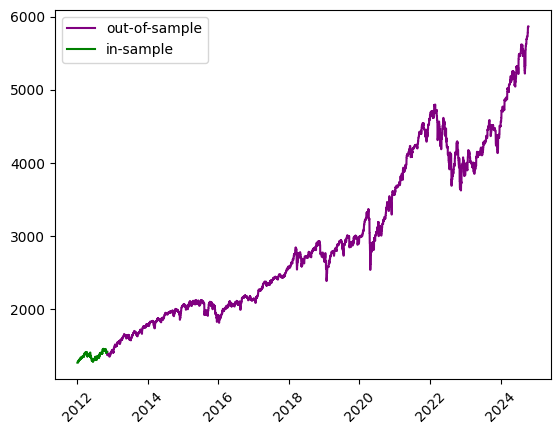

In [8]:
from convsklearn import convsklearn
trainer = convsklearn()
trainer.mlp_params = tuned_params
trainer.excluded_features = trainer.excluded_features + ['spot_price','strike_price','barrier','rebate',relative_pricename,'relative_observed']
trainer.load_data(data)
dates = data['date'].sort_values().drop_duplicates().reset_index(drop=True)
development_dates = dates[:100]
test_dates = dates[~dates.isin(development_dates)]
trainer.target_name = targetname
trainer.preprocess_data(development_dates=development_dates,test_dates=test_dates)

In [9]:
help(trainer)

Help on convsklearn in module convsklearn.convsklearn object:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  fit_mlp(self, print_details=True)
 |
 |  fit_scaled_target_mlp(self, print_details=True)
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __w

In [10]:
trainer.fit_mlp()
trainer.test_prediction_accuracy()


training on 23580 samples...

hidden_layer_sizes: (10, 10)
max_iter: 500
random_state: 1312
early_stopping: True
learning_rate: constant
learning_rate_init: 0.1
n_iter_no_change: 20
power_t: 0.5
tol: 0.0001
cpu: 0.3530850410461426

in sample:
     RMSE: 0.005462875910445546
     MAE: 0.0035040406118745236

out of sample:
     RMSE: 0.1866793449274704
     MAE: 0.10429109815687158


{'train_data':         spot_price  strike_price  days_to_maturity  n_fixings  \
 28980       1274.0         637.0                 7        1.0   
 29096       1274.0        1911.0                84        1.0   
 29097       1274.0        1911.0                84        1.0   
 29098       1274.0        1911.0                84        1.0   
 29099       1274.0        1911.0                84        1.0   
 ...            ...           ...               ...        ...   
 264896      1420.0        2130.0                84        1.0   
 264895      1420.0        1775.0                84        1.0   
 264894      1420.0        1775.0                84        1.0   
 264892      1420.0        1775.0                84        1.0   
 264868      1420.0        1420.0                84        3.0   
 
         fixing_frequency  past_fixings averaging_type     w  risk_free_rate  \
 28980                  7             0      geometric  call        0.001578   
 29096                 84       